In [1]:
%pylab inline
import pandas as pd
import numpy as np
import os
import geopandas as gpd
from geopandas import GeoDataFrame, read_file
from geopandas.tools import sjoin
from shapely.geometry import Point, mapping,shape
import time
import matplotlib.pyplot as plt
from fiona import collection
import json

Populating the interactive namespace from numpy and matplotlib


In [2]:
bikes = gpd.read_file('../data/vz311/bikes.geojson')
bikes.head()

,AllClasses,BORO,BikeDir,CarFreeHrs,Comments,FACILITYCL,FROMSTREET,FT_Facilit,InstDate,LaneCount,ModDate,OBJECTID,OnOffSt,SegmentID,Shape_Leng,Street,TF_Facilit,TOSTREET,geometry
0,II,3,L,None,None,II,ATLANTIC AV,None,2008-05-01,1,2008/05/01,1,ON,0158196,27.594231,BOERUM PL,Curbside,FULTON ST,(LINESTRING (-73.98920133231049 40.69104037686...
1,II,3,L,None,None,II,ATLANTIC AV,None,2008-05-01,1,2008/05/01,2,ON,0158195,388.356099,BOERUM PL,Curbside,FULTON ST,(LINESTRING (-73.98893356281089 40.69208665754...
2,III,3,R,None,None,III,FULTON ST,Sharrows,2008-05-01,1,2008/05/01,3,ON,0158055,41.893490,ADAMS ST,None,SANDS ST,(LINESTRING (-73.9890620141085 40.692418625929...
3,I,3,2,None,None,I,CLINTON ST,Protected Path,2005-11-01,2,2005/11/01,4,ON,0157983,304.905674,TILLARY ST,Protected Path,ADAMS ST,(LINESTRING (-73.99112993192688 40.69635795276...
4,III,3,R,None,None,III,BERGEN ST,Sharrows,2008-09-13,1,2008/09/13,5,ON,0022428,126.078700,COURT ST,None,KANE ST,(LINESTRING (-73.99425367928984 40.68577801361...


In [3]:
bikes.shape

(10932, 19)

In [4]:
# ixName = "../data/vz311/intersectionNodes.geojson"
ixName = "../data/vz311/intersectionNodes2.geojson"
intersections = gpd.read_file(ixName)

In [5]:
intersections.shape

(126240, 3)

In [6]:
intersections.head()

,NODEID,VIntersect,geometry
0,1,,POINT (-74.25702151185868 40.49414563819848)
1,2,,POINT (-74.24443849259721 40.4922776914055)
2,3,,POINT (-74.25874354305617 40.49704148607953)
3,4,,POINT (-74.25874745972355 40.50270602375195)
4,5,,POINT (-74.25850081677106 40.50810821233416)


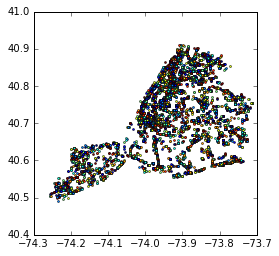

In [7]:
f = plt.figure()
intersections.tail(9000).plot()

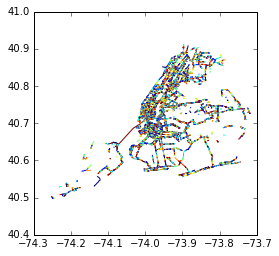

In [8]:
bikes.plot()

In [9]:
# buf = 1. / 69 / 10 # ~69 miles per decimal degree, so this gives ~0.1 mile
# buf = 1. / 69 / 10 / 2 # ~69 miles per decimal degree, so this gives ~0.05 mile
buf = 1. / 69 / 10 / 4 # ~69 miles per decimal degree, so this gives ~0.025 mile
print '{} decimal degrees'.format(buf)

0.00036231884058 decimal degrees


In [10]:
bikes2 = bikes

In [11]:
start=time.time()
bikes2['geometry'] = bikes2['geometry'].buffer(buf)
print 'time to create buffers:', time.time()-start

time to create buffers: 1.50448513031


In [12]:
bikes2.head()

,AllClasses,BORO,BikeDir,CarFreeHrs,Comments,FACILITYCL,FROMSTREET,FT_Facilit,InstDate,LaneCount,ModDate,OBJECTID,OnOffSt,SegmentID,Shape_Leng,Street,TF_Facilit,TOSTREET,geometry
0,II,3,L,None,None,II,ATLANTIC AV,None,2008-05-01,1,2008/05/01,1,ON,0158196,27.594231,BOERUM PL,Curbside,FULTON ST,"POLYGON ((-73.9888686549123 40.69087763670097,..."
1,II,3,L,None,None,II,ATLANTIC AV,None,2008-05-01,1,2008/05/01,2,ON,0158195,388.356099,BOERUM PL,Curbside,FULTON ST,POLYGON ((-73.98885032620774 40.69095054558995...
2,III,3,R,None,None,III,FULTON ST,Sharrows,2008-05-01,1,2008/05/01,3,ON,0158055,41.893490,ADAMS ST,None,SANDS ST,POLYGON ((-73.98868940328275 40.69234297585093...
3,I,3,2,None,None,I,CLINTON ST,Protected Path,2005-11-01,2,2005/11/01,4,ON,0157983,304.905674,TILLARY ST,Protected Path,ADAMS ST,POLYGON ((-73.99104798824317 40.69671999307978...
4,III,3,R,None,None,III,BERGEN ST,Sharrows,2008-09-13,1,2008/09/13,5,ON,0022428,126.078700,COURT ST,None,KANE ST,POLYGON ((-73.99408064544548 40.68529727712878...


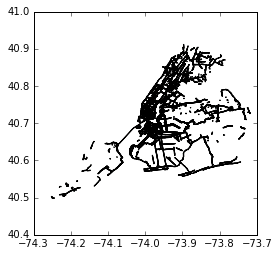

In [13]:
bikes2.plot()

In [14]:
# for later:
start=time.time()
# bikeMerge=sjoin(intersections, bikes2, how='left', op='intersects')
bikeMerge=sjoin(intersections, bikes2, how='left', op='within')
print 'time to merge:', time.time()-start

time to merge: 15.6419379711


In [15]:
bikeMerge.shape

(167317, 22)

In [16]:
bikeMerge[bikeMerge['index_right'].notnull()].shape

(65034, 22)

In [17]:
intersections.shape

(126240, 3)

In [18]:
bikeMerge2 = bikeMerge

In [19]:
bikeMerge2['bikeLane'] = 0

In [20]:
idx = pd.IndexSlice

In [21]:
mask = bikeMerge2.loc[:,idx['index_right']].notnull()

In [22]:
bikeMerge2.loc[mask, 'bikeLane'] = 1

In [23]:
bikeMerge3 = bikeMerge2[['NODEID', 'bikeLane']]

In [24]:
bikeMerge3.shape

(167317, 2)

In [25]:
bikeMerge3.drop_duplicates().shape

(126240, 2)

In [26]:
bikeMerge3 = bikeMerge3.drop_duplicates()

In [27]:
bikeMerge3 = bikeMerge3.rename(columns={'NODEID': 'intersectionID'})

In [30]:
# bikeMerge3.to_csv('../data/bikeLanes.csv')

In [28]:
bikeMerge3[bikeMerge3['bikeLane']==1].shape

(23957, 2)

with buf = 1. / 69 / 10  
44200 matches

with buf = 1. / 69 / 10 / 2  
30497 matches

with buf = 1. / 69 / 10 / 4  
23957 matches

In [29]:
# bikes2.to_csv('../data/bikeBufferWider.csv')
# bikes2.to_csv('../data/bikeBufferNarrow.csv')

In [32]:
vz = pd.read_csv('../data/vzwV2.csv')

In [33]:
vz.head()

,identity,label,NUMBER_OF_PERSONS_INJURED,NUMBER_OF_PERSONS_KILLED,NUMBER_OF_PEDESTRIANS_INJURED,NUMBER_OF_PEDESTRIANS_KILLED,NUMBER_OF_CYCLIST_INJURED,NUMBER_OF_CYCLIST_KILLED,NUMBER_OF_MOTORIST_INJURED,NUMBER_OF_MOTORIST_KILLED,...,VEHICLE_TYPE_CODE_5-nan,Street_Condition,Traffic_Signal_Condition,Visibility,WetBulbFarenheit,WindSpeed,Precip,PrecipSum,intersectionID,total_involved
0,id-0,0,0,0,0,0,0,0,0,0,...,0,0,0,10,21.666667,8.333333,0,-2.239962e-16,1,0
1,id-1,0,0,0,0,0,0,0,0,0,...,0,0,0,10,55.333333,16.333333,0,-1.971080e-16,2,0
2,id-2,0,0,0,0,0,0,0,0,0,...,0,0,0,10,25.333333,9.666667,0,-2.272488e-16,3,0
3,id-3,0,0,0,0,0,0,0,0,0,...,0,0,0,10,47.000000,8.333333,0,-2.376571e-16,4,0
4,id-4,0,0,0,0,0,0,0,0,0,...,0,0,0,10,45.666667,10.500000,0,-1.903859e-16,5,0


In [42]:
vzMerge = pd.merge(vz, bikeMerge3, how='left', on='intersectionID')

In [43]:
bikeMerge3.shape

(126240, 2)

In [44]:
vz.shape

(277255, 281)

In [45]:
vzMerge.shape

(277255, 282)

In [49]:
vzMerge.to_csv('../data/vzwV3.csv')